## Download a youtube video

In [1]:
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 KB 748.6 kB/s eta 0:00:00


In [2]:
from pytube import YouTube

In [3]:
def Download(link):
    youtubeObject = YouTube(link)
    youtubeObject = youtubeObject.streams.get_highest_resolution()
    try:
        youtubeObject.download(output_path="")
    except:
        print("An error has occurred")
    print("Download is completed successfully")

In [4]:
link = "https://www.youtube.com/watch?v=HSPYgwP9R84"
# Download(link)

## Object detection

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.4 MB/s eta 0:00:00


In [6]:
import cv2
import numpy as np
import torch.cuda
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
from tqdm.notebook import tqdm
import threading
import time

from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image
from itertools import product

In [7]:
def frame_to_tensor(frame: np.ndarray):
    transform = transforms.ToTensor()
    frame_t = transform(frame)
    return frame_t

In [8]:
def get_frame_patches(frame: np.ndarray, patch_size):
    """
    Function to split the frame into patches of size @patch_dim
    :param frame: the frame of the video
    :param patch_size: the dimension of the patches
    :return: the patches
    """
    frame_t = frame_to_tensor(frame)
    # unfold the tensor along the 0-dimension to get the batch dimension
    patches = frame_t.data.unfold(0, 3, 3)

    # create vertical patches (in the height dimension)
    patches = patches.unfold(1, patch_size, patch_size)

    # create horizontal patches (in width dimension)
    patches = patches.unfold(2, patch_size, patch_size)

    print(f"Shape of the patches = {patches.shape}")
    return patches

In [9]:
def load_model(model_id="openai/clip-vit-base-patch32"):
    """
    Function to load the transformer model and the respective preprocessor
    :param model_id: id of the model to load
    :return: the processor and the model requested
    """
    processor = CLIPProcessor.from_pretrained(model_id)
    model = CLIPModel.from_pretrained(model_id)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    return model, processor, device

In [10]:
def run_inference(model, processor, device, prompt, patches, patch_size, window, stride):
    """
    Function to run the model and get the similarity scores
    :param model: the Visual Transformer to be run
    :param processor: the processor associated to the Transformer to run
    :param device: the hardware devoted to run the model
    :param patches: the patches drawn from the frame
    :param patch_size: the size of the patches
    :param window: the amount of patches seen by the model
    :return: scores associated to the big patches
    """
    scores = torch.zeros(patches.shape[1], patches.shape[2])
    runs = torch.ones(patches.shape[1], patches.shape[2])

    for Y in range(0, patches.shape[1]-window+1, stride):
        for X in range(0, patches.shape[2]-window+1, stride):
            big_patch = torch.zeros(patch_size * window, patch_size * window, 3)
            patch_batch = patches[0, Y:Y+window, X:X+window]
            for y in range(window):
                for x in range(window):
                    big_patch[
                    y * patch_size:(y + 1) * patch_size, x * patch_size:(x + 1) * patch_size, :
                    ] = patch_batch[y, x].permute(1, 2, 0)
            # we preprocess the image and class label with the CLIP processor
            inputs = processor(
                images=big_patch,  # big patch image sent to CLIP
                return_tensors="pt",  # tell CLIP to return pytorch tensor
                text=prompt,  # class label sent to CLIP
                padding=True
            ).to(device) # move to device if possible

            # calculate and retrieve similarity score
            score = model(**inputs).logits_per_image.item()
            # sum up similarity scores from current and previous big patches
            # that were calculated for patches within the current window
            scores[Y:Y+window, X:X+window] += score
            # calculate the number of runs on each patch within the current window
            runs[Y:Y+window, X:X+window] += 1
    # calculate average scores
    scores /= runs
    # clip scores
    for _ in range(3):
        scores = np.clip(scores-scores.mean(), 0, np.inf)
    # normalize scores
    scores = (scores - scores.min()) / (scores.max() - scores.min())
    #scores = (scores - scores.mean()) / scores.std()
    #print(f'The max score is {scores.max()}, while the min score is {scores.min()}')
    return scores

In [11]:
def get_box(scores, patch_size, threshold):
    detection = scores > threshold
    # find box corners
    y_min, y_max = np.nonzero(detection)[:, 0].min().item(), np.nonzero(detection)[:, 0].max().item()+1
    x_min, x_max = np.nonzero(detection)[:, 1].min().item(), np.nonzero(detection)[:, 1].max().item()+1
    print(f'The x_min is {x_min} and x_max is {x_max} and their scores are {(np.nonzero(detection)[:, 1].min()), np.nonzero(detection)[:, 1].max()}')
    print(f'The detection for the y is {np.nonzero(detection)[:, 0]}')
    print(f'The detection for the x is {np.nonzero(detection)[:, 1]}')
    # convert from patch co-ords to pixel co-ords
    y_min *= patch_size
    y_max *= patch_size
    x_min *= patch_size
    x_max *= patch_size
    # calculate box height and width
    height = y_max - y_min
    width = x_max - x_min
    return x_min, y_min, width, height

In [12]:
def get_multi_box(scores, patch_size, threshold):

    # Convert the scores to a numpy array if it's a tensor
    if torch.is_tensor(input):
      scores = scores.numpy()
    # print(f"The scores' shape si {scores.shape}")

    # Print the scores as an image to see the locations
    '''
    print(f'Printing the scores matrix')
    row_string = ''
    for row in scores:
      for col in row:
        row_string += '{:2f} '.format(col)
      row_string += '\n'
    print(row_string)
    '''

    # Define the matrix with only the good scores
    detection = np.zeros((scores.shape))

    # Consider only the region of interest in the image
    detection[scores > threshold] = scores[scores > threshold]
    # detection = np.nonzero(detection)
    print(f'The shape of the detection is {detection.shape}')

    # Print the scores as an image to see the locations
    '''
    print(f'Printing the detection matrix')
    row_string = ''
    for row in detection:
      for col in row:
        row_string += '{:2f} '.format(col)
      row_string += '\n'
    print(row_string)
    '''

    bb_dict = {}
    finished = False
    bb_finished = False
    bb_idx = 0
    x_coo = 0
    y_coo = 0
    elem_to_check = []
    num_cells_different_from_zero = 0

    while not finished:
      # Init the dictionary
      bb_dict[bb_idx] = {}
      bb_dict[bb_idx]['x'] = []
      bb_dict[bb_idx]['y'] = []
      # Add the current element to the check list
      elem_to_check.append((x_coo, y_coo))
      # Till there are elements to check
      while len(elem_to_check) > 0:
        current_position = elem_to_check.pop(0)
        # If the current location is different from zero
        # print(f'Current cells is {current_position}')
        if detection[current_position[0], current_position[1]] != 0:
          num_cells_different_from_zero += 1
          # Add the current elem to the dict
          bb_dict[bb_idx]['x'].append(current_position[0])
          bb_dict[bb_idx]['y'].append(current_position[1])
          # Set to zero the location already added
          detection[current_position[0], current_position[1]] = 0
          # Check the 4 cells around if they are still valid cells
          if current_position[1]+1 < detection.shape[1]:
            elem_to_check.append((current_position[0], current_position[1]+1))
          if current_position[0]+1 < detection.shape[0]:
            elem_to_check.append((current_position[0]+1, current_position[1]))
          if current_position[0]-1 >= 0:
            elem_to_check.append((current_position[0]-1, current_position[1]))
          if current_position[1]-1 >= 0:
            elem_to_check.append((current_position[0], current_position[1]-1))
            
      # Go to the next bb
      bb_idx += 1
      # Update x_coo and y_coo
      if x_coo < detection.shape[0] - 1:
        x_coo += 1
      elif y_coo < detection.shape[1] - 1:
        x_coo = 0
        y_coo += 1
      else: 
        # If in the last position
        finished = True
    print(f'Finished the computation of the bounding boxes')

    final_list_of_bb = []
    for key, item in bb_dict.items():
      x_values = item['x']
      y_values = item['y']

      if len(x_values) > 0 and len(y_values) > 0:

        '''
        print(f'The points in the bounding box {key} are: ')
        print(f'x: {x_values}')
        print(f'y: {y_values}')
        '''

        # find box corners
        y_min, y_max = min(y_values), max(y_values)+1
        x_min, x_max = min(x_values), max(x_values)+1

        # convert from patch co-ords to pixel co-ords
        y_min *= patch_size
        y_max *= patch_size
        x_min *= patch_size
        x_max *= patch_size

        # calculate box height and width
        width = y_max - y_min
        height = x_max - x_min

        # Append the bb
        final_list_of_bb.append((y_min, x_min, width, height))

    # Return the whole list
    print(f'The number of boxes detected is {len(final_list_of_bb)}')
    print(f'The number of cells different from zero is {num_cells_different_from_zero}')
    return final_list_of_bb

In [13]:
def detect(model, processor, device, prompts, frame, patch_size=64, window=3, stride=1, threshold=0.5, single_box=True):
    """
    Function to the detect the objects in the frame. It uses the frames to look for the specified items.
    It creates a plot of the image containing the detected objects.
    :param model: model to run for the inference
    :param processor: processor associated to the model
    :param device: the hardware used to run the inference
    :param prompts: the objects to find in the frame
    :param frame: the specified frame
    :param patch_size: the size of the patches
    :param window: the amount of patches to search in simultaneously
    :return: the bounding box parameters
    """
    colors = ['#FAFF00', '#8CF1FF']
    # build image patches for detection
    frame_patches = get_frame_patches(frame, patch_size)
    frame_t = frame_to_tensor(frame)
    # convert image to format for displaying with matplotlib
    """
    image = np.moveaxis(frame_t.data.numpy(), 0, -1)
    X = frame_patches.shape[1]
    Y = frame_patches.shape[2]
    # initialize plot to display image + bounding boxes
    fig, ax = plt.subplots(figsize=(Y*0.5, X*0.5))
    ax.imshow(image)
    """
    bounding_box_list = []
    # process image through object detection steps
    for i, prompt in enumerate(tqdm(prompts)):
        scores = run_inference(model, processor, device, prompt, frame_patches, patch_size, window, stride)
        if single_box:
          x, y, width, height = get_box(scores, patch_size, threshold)
          if width > 0 and height > 0:
            bounding_box_list.append((x, y, width, height))
        else: # If multi box
          bb_list = get_multi_box(scores, patch_size, threshold)
          for bb in bb_list:
            bounding_box_list.append(bb)
        # create the bounding box
        # rect = pltpatches.Rectangle((x, y), width, height, linewidth=3, edgecolor=colors[i], facecolor='none')
        # cv2.rectangle(frame, (x, y), (x+width, y+height), [0, 255, 0])
        # add the patch to the Axes
        # ax.add_patch(rect)
    # cv2.imshow("Frame", frame)
    return bounding_box_list

## Online Object Detection

In [14]:
def show_video_and_detect(input_file_path, prompts):
    """
    Function to show the video in an external window.
    When the video is paused the detection algorithm is run with the specified prompts.
    @param: input_file_path path of the video to be shown
    """
    # Show the video
    capture = cv2.VideoCapture(input_file_path)
    frame_width = capture.get(cv2.CAP_PROP_FRAME_WIDTH)
    frame_height = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = np.ceil(capture.get(cv2.CAP_PROP_FPS))
    print(f"fps:{fps:.2f}, frame width: {frame_width}, frame height: {frame_height}")

    model, processor, device = load_model()

    while capture.isOpened():
        ret, frame = capture.read()

        if ret:
            clear_output(wait=True)
            cv2_imshow(frame)
            # Press Q on keyboard to exit
            key = cv2.waitKey(25)
            if key & 0xFF == ord('q'):
                break
            elif key == 32:
                t0 = time.time()
                detect(model, processor, prompts=prompts, device=device, frame=frame)
                t1 = time.time()
                print(f"Time for detection = {t1-t0}")
                cv2.waitKey()
        # Break the loop
        else:
            break
    # When everything done, release
    # the video capture object
    capture.release()

    # Closes all the frames
    cv2.destroyAllWindows()

In [15]:
# show_video_and_detect("/content/The Devil Wears Prada (45) Movie CLIP - Andy Gets a Makeover (2006) HD.mp4", prompts=["black t-shirt"])

##  Offline object detection


In [16]:
!pip install pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
!pip install youtube_dl==2020.12.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.8 MB/s eta 0:00:00


In [18]:
import pafy
import random
import youtube_dl
import cv2 as cv
from tqdm import tqdm

In [19]:
# Get the videon 
ydl_opts = {}
ydl=youtube_dl.YoutubeDL(ydl_opts)
info_dict=ydl.extract_info("https://www.youtube.com/watch?v=HSPYgwP9R84", download=False)
formats = info_dict.get('formats', None)
for f_number, f in enumerate(formats):
  if f.get('format_note', None) == '360p' and f.get('ext', None) == 'mp4' and f.get('filesize', None) != None:
    print(f)

[youtube] HSPYgwP9R84: Downloading webpage
{'format_id': '396', 'url': 'https://rr1---sn-5hnekn7z.googlevideo.com/videoplayback?expire=1682041392&ei=0JVBZK3RLpTI7gPI9qLAAg&ip=34.90.82.106&id=o-AGawaLjc3mL5XWwcNU38WOqqHMI87YefYJxpEH26EO_X&itag=396&aitags=133%2C134%2C135%2C136%2C137%2C160%2C242%2C243%2C244%2C247%2C248%2C278%2C394%2C395%2C396%2C397%2C398%2C399&source=youtube&requiressl=yes&mh=6q&mm=31%2C29&mn=sn-5hnekn7z%2Csn-5hne6nzk&ms=au%2Crdu&mv=u&mvi=1&pl=25&vprv=1&mime=video%2Fmp4&ns=-6Kcie85oI0lWyWGgoLHcZMM&gir=yes&clen=3911216&dur=159.534&lmt=1617694467598556&mt=1682019301&fvip=2&keepalive=yes&fexp=24007246&c=WEB&txp=5531432&n=XmUF_gcSP-bIx-&sparams=expire%2Cei%2Cip%2Cid%2Caitags%2Csource%2Crequiressl%2Cvprv%2Cmime%2Cns%2Cgir%2Cclen%2Cdur%2Clmt&sig=AOq0QJ8wRAIgEHasfOArJcyHdr86nRUBYgVqHzbjLDsq3zLJWucF-9ECICr8tHUfy7YpIU6qR_xEr0VmogJ3fvHPKCAKPJ-DIh-c&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl&lsig=AG3C_xAwRAIgeuytI37ntjv4IERQqfYJvAiZKqk39IXIxq2VN1Grm4oCIDD5hFDHBWKfuse7U0RbhxXaVndvS2-

Code to adjust the frame

In [20]:
def adjust_frame(frame, patch_size):
  def reduce_size_black_rows(frame, patch_size, upper_limit, lower_limit):
    """
    Performs in-place reduction of the size of the black rows
    """
    zeros_row = np.zeros(frame.shape[1:]).astype(int)
    indices = np.array([i for i in range(frame.shape[0]) if (frame[i,:,:] == zeros_row).all()])
    if len(indices) > 0:
      upper_indices = indices[indices <= lower_limit]
      lower_indices = indices[indices >= upper_limit]
      #print(f'The shape of the frame is {frame.shape}')
      #print(f'The shape of upper_indices is {upper_indices.shape}')
      #print(f'The shape of lower_indices is {lower_indices.shape}')
      # a border = patch_size/2 is left at the top and the bottom of the frame
      if upper_indices.shape[0] > 0:
        min_row_idx = max([upper_indices[len(upper_indices)-1] - int(patch_size/2),0])
      else:
        min_row_idx = 0
      if lower_indices.shape[0] > 0:
        max_row_idx = min([lower_indices[0] + int(patch_size/2),frame.shape[0]])
      else:
        max_row_idx = frame.shape[0]
      
      rows_idxs = np.zeros(frame.shape[0]).astype(bool)
      rows_idxs[min_row_idx:max_row_idx+1] = 1

      return frame[rows_idxs,:,:]
    return frame


  def add_black_columns(frame, patch_size):
    """
    Performs in-place black columns concatenation to frame
    """
    n_columns = int(patch_size/2)
    vertical_black_col = np.zeros((frame.shape[0],n_columns,3)).astype(int)
    frame = np.concatenate((frame,vertical_black_col), axis=1)
    frame = np.concatenate((vertical_black_col,frame), axis=1)
    return frame


  #frame = reduce_size_black_rows(frame, patch_size, upper_limit=430, lower_limit=50)
  frame = add_black_columns(frame, patch_size)

  return frame

In [21]:
def detect_objects(video_url, prompts, frame_per_second=5, patch_size=64, window=3, stride=1, threshold=0.5, single_box=True, frames_union=None):
  """
  Function to detect the specified object in each frame of the video
  @param: video_url is the link to the video to analyse
  @param: prompts is a list of texts descriving the objects to detect
  @param: frame_per_second is the number of frame to analyse in a second
  @param: it indicates the number of frames to concatenate in the same image
  @param: the others are related to the object detection
  """
  # Get the video
  ydl_opts = {}
  ydl=youtube_dl.YoutubeDL(ydl_opts)
  info_dict=ydl.extract_info(video_url, download=False)

  # Instanciate the lists
  images_list = []
  filenames_list = []
  bounding_box_list = []

  model, processor, device = load_model()

  formats = info_dict.get('formats', None)
  print("Obtaining frames")
  for f_number, f in enumerate(formats):

    # If the resolution is 360p and if the format is webm (faster than mp4)
    if f.get('format_note', None) == '360p' and f.get('ext', None) == 'webm' and f.get('filesize', None) != None:
      # Get the url
      url = f.get('url', None)

      # Define how many frames to skip between each analysis
      skip_frames = int(f['fps'] / frame_per_second)

      cap = cv.VideoCapture(url)
      current_frame = 0
      t0 = time.time()
      # Till the end of the video
      while True:
        print(f'Computing frame number {len(images_list)}')
        # Get the frame
        ret, frame = cap.read()

        if not ret:
            print(f'Finished the video')
            break

        # Add columns to the frame to improve the quality of the detections
        frame = adjust_frame(frame, patch_size)


        # Define a name for the frame
        filename = r"video_shot" + str(len(images_list)) + ".png"
        # If save the frame
        # cv.imwrite(filename, frame)
        # Append the frame and the filename in the lists
        images_list.append(frame)
        filenames_list.append(filename)
        bounding_boxes = detect(model,
                                processor, 
                                prompts=prompts, 
                                device=device, 
                                frame=frame,
                                patch_size=patch_size, 
                                window=window, 
                                stride=stride, 
                                threshold=threshold,
                                single_box=single_box)
        bounding_box_list.append(bounding_boxes)

        # Skip some frames
        current_frame += skip_frames
        cap.set(1, current_frame)
        if cv.waitKey(30) & 0xFF == ord('q'):
            break
      print("Saved {} images with format {} and resolution {} in {:.4} seconds ({:.4} minutes)".format(len(images_list), f.get('ext', None), f.get('format_note',None), (time.time() - t0), (time.time() - t0) / 60 ))
      # If a valid format has been found and analysed
      # if len(images_list) > 0:
      #  break
      # cap.release()
  # Return the lists
  return  images_list, filenames_list, bounding_box_list

In [22]:
def show_frames(images, row_dim=4, num_of_images=None):
  """
  Function to show all the frames in the list
  @params: images is the list of images
  @params: row_dim is the number of images to show in a row
  @param: num_of_images indicates how many images to show
  """
  if num_of_images == None or num_of_images <= 0 or num_of_images > len(images):
    num_of_images = len(images)

  fig, axs = plt.subplots(int(num_of_images / row_dim) + 1, row_dim, figsize=(20, len(images[0][0]) // row_dim))

  for i in tqdm(range(num_of_images)):
    axs[int(i/row_dim), i%row_dim].imshow(images[i])
    axs[int(i/row_dim), i%row_dim].set_title('Frame: {}'.format(i))

  plt.plot()

In [47]:
def show_frames_with_bounding_box(images_list, bounding_boxes, row_dim=6, num_of_images=None):
  """
  Function to show all the frames in the list with the found bounding box
  @params: images_list is the list of images
  @params: bounding_boxes is a list of bounding box associated with the images.
            For each image there a list of tuple: (x, y, width, heigth)
  @params: row_dim is the number of images to show in a row
  @param: num_of_images indicates how many images to show
  """
  # Create a copy of the list
  images = [image.astype(np.uint8) for image in images_list]

  if num_of_images == None or num_of_images <= 0 or num_of_images > len(images):
    num_of_images = len(images)

  if int(num_of_images / row_dim) == 1:
    fig, axs = plt.subplots(int(num_of_images / row_dim), row_dim, figsize=(20, len(images[0][0]) // row_dim))  
    for i in tqdm(range(num_of_images)):
      # If there is at least one box
      if len(bounding_boxes[i]) > 0:
        # img = np.array(images[i])
        for bb in bounding_boxes[i]:
          images[i] = cv2.rectangle(images[i], # frame
                        (bb[0], # x
                        bb[1]),# y 
                        (bb[0]+bb[2], # width
                        bb[1]+bb[3]),# length 
                        (random.randint(128, 255), random.randint(128, 255), random.randint(128, 255))) # random color
        axs[i%row_dim].imshow(images[i])
        axs[i%row_dim].set_title('Frame: {}'.format(i))

    plt.plot()
    return


  fig, axs = plt.subplots(int(np.ceil(num_of_images / row_dim)), row_dim, figsize=(20, len(images[0][0]) // row_dim))

  for i in tqdm(range(num_of_images)):
    # If there is at least one box
    if len(bounding_boxes[i]) > 0:
      # img = np.array(images[i])
      for bb in bounding_boxes[i]:
        images[i] = cv2.rectangle(images[i], # frame
                      (bb[0], # x
                       bb[1]),# y 
                      (bb[0]+bb[2], # width
                       bb[1]+bb[3]),# length 
                      (random.randint(128, 255), random.randint(128, 255), random.randint(128, 255))) # random color
    axs[int(i/row_dim), i%row_dim].imshow(images[i])
    axs[int(i/row_dim), i%row_dim].set_title('Frame: {}'.format(i))

  plt.plot()

In [24]:
'''images_list, image_names_list, bounding_box_list = detect_objects(
    video_url="https://www.youtube.com/watch?v=HSPYgwP9R84", # The devil wears Prada
    # prompts=["a lamp", "a black jacket"],
    prompts=["a lamp"],
    frame_per_second=0.1, 
    patch_size=18, 
    window=10,
    stride=1, 
    threshold=0.2,
    single_box=False,
    frames_union=4)
  '''

'images_list, image_names_list, bounding_box_list = detect_objects(\n    video_url="https://www.youtube.com/watch?v=HSPYgwP9R84", # The devil wears Prada\n    # prompts=["a lamp", "a black jacket"],\n    prompts=["a lamp"],\n    frame_per_second=0.1, \n    patch_size=18, \n    window=10,\n    stride=1, \n    threshold=0.2,\n    single_box=False,\n    frames_union=4)\n  '

In [25]:
'''images_list, image_names_list, bounding_box_list = detect_objects(
    video_url="https://www.youtube.com/watch?v=NsRLOV4pHyk&t=6s", # iron-man vs Loki
    prompts=["a green t-shirt"],
    frame_per_second=0.1, 
    patch_size=24, 
    window=10,
    stride=1, 
    threshold=0.1,
    single_box=False)
  '''

'images_list, image_names_list, bounding_box_list = detect_objects(\n    video_url="https://www.youtube.com/watch?v=NsRLOV4pHyk&t=6s", # iron-man vs Loki\n    prompts=["a green t-shirt"],\n    frame_per_second=0.1, \n    patch_size=24, \n    window=10,\n    stride=1, \n    threshold=0.1,\n    single_box=False)\n  '

In [26]:
#print(f'The number of frames is {len(images_list)}')

In [27]:
# show_frames(images=images_list, row_dim=8, num_of_images=None)

In [28]:
# show_frames_with_bounding_box(images_list=images_list, bounding_boxes=bounding_box_list, row_dim=2, num_of_images=None)

## Let's try to concatenate frames before the detections to avoid useless detections

In [29]:
def get_video_frames(video_url, resolution='480p', frame_per_second=5, frames_union=None, patch_size=64):
  """
  Function to detect the specified object in each frame of the video
  @param: video_url is the link to the video to analyse
  @param: resolution is the resolution of the video to acquire
  @param: frame_per_second is the number of frame to analyse in a second
  @param: frames_union it indicates the number of frames to concatenate in the same image
  """
  # Get the video
  ydl_opts = {}
  ydl=youtube_dl.YoutubeDL(ydl_opts)
  info_dict=ydl.extract_info(video_url, download=False)

  # Instanciate the list
  images_list = []

  # Check the resolution
  list_of_available_resolutions = ['240p', '360p', '480p', '720p']
  if resolution not in list_of_available_resolutions:
    resolution = list_of_available_resolutions[0]

  formats = info_dict.get('formats', None)
  print("Obtaining frames")
  for f_number, f in enumerate(formats):

    # If the resolution is 360p and if the format is webm (faster than mp4)
    if f.get('format_note', None) == resolution and f.get('ext', None) == 'webm' and f.get('filesize', None) != None:
      # Get the url
      url = f.get('url', None)

      # Define how many frames to skip between each analysis
      skip_frames = int(f['fps'] / frame_per_second)

      cap = cv.VideoCapture(url)
      current_frame = 0
      t0 = time.time()
      # Till the end of the video
      while True:
        print(f'Computing frame number {len(images_list)}')
        # Get the frame
        ret, frame = cap.read()

        if not ret:
            print(f'Finished the video')
            break

        # Add columns to the frame to improve the quality of the detections
        frame = adjust_frame(frame, patch_size)

        # Save the shape of the frame
        frame_dimension = frame.shape

        # If save the frame
        # cv.imwrite(filename, frame)
        # Append the frame and the filename in the lists
        images_list.append(frame)

        # Skip some frames
        current_frame += skip_frames
        cap.set(1, current_frame)
        if cv.waitKey(30) & 0xFF == ord('q'):
            break
      print("Saved {} images with format {} and resolution {} in {:.4} seconds ({:.4} minutes)".format(len(images_list), f.get('ext', None), f.get('format_note',None), (time.time() - t0), (time.time() - t0) / 60 ))
      # If a valid format has been found and analysed
      # if len(images_list) > 0:
      #  break
      # cap.release()

  # Check if need to concatenate images, if not return the images
  if frames_union == None or frames_union <= 0:
    # Return the lists
    return  images_list

  # TODO: right now it's just a 2x2 concatenation: generalize it if it works
  print(f'The number of frames is {len(images_list)}')

  # If here, concatenate frames
  # First, concatenate pairs of frames horizontally
  horizontal_pairs = []
  # Define a bool variable to know if the last images in the h pairs is alone
  final_single_image = False

  for i in range(0, len(images_list), 2):
    # print(f'Computing horizontal aggregation number {i}')
    # If there is a pair
    if i+1 < len(images_list):
      horizontal_pairs.append(cv2.hconcat([images_list[i], images_list[i+1]]))
    elif i < len(images_list):
      # Add the single image
      horizontal_pairs.append(images_list[i])
      # Save that the last image is single
      final_single_image = True

  print(f'The number of horizontal pairs is {len(horizontal_pairs)}')
  
  # Now let's concatenate the pairs vertically
  vertical_pairs = []

  for i in range(0, len(horizontal_pairs), 2):
    # print(f'Computing vertical aggregation number {i}')
    if not final_single_image:
    # Append the pair if it's not the last one
      if i+1 < len(horizontal_pairs):
        vertical_pairs.append(cv2.vconcat([horizontal_pairs[i], horizontal_pairs[i+1]]))
      elif i < len(horizontal_pairs):
        vertical_pairs.append(horizontal_pairs[i])
    else:
      # If the number of images is even
      if len(horizontal_pairs) % 2 == 0:
        if i < len(horizontal_pairs)-2:
          # Concatenate the images
          vertical_pairs.append(cv2.vconcat([horizontal_pairs[i], horizontal_pairs[i+1]]))
        else:
          # Append the last 2 images as they are
          vertical_pairs.append(horizontal_pairs[i])
          vertical_pairs.append(horizontal_pairs[i+1])
  
  print(f'The number of vertical pairs is {len(vertical_pairs)}')

  # Return the list
  return vertical_pairs, frame_dimension

In [30]:
def get_scores(model, processor, device, prompts, frame, patch_size=64, window=3, stride=1):
    """
    Function to the detect the objects in the frame. It uses the frames to look for the specified items.
    It creates a plot of the image containing the detected objects.
    :param model: model to run for the inference
    :param processor: processor associated to the model
    :param device: the hardware used to run the inference
    :param prompts: the objects to find in the frame
    :param frame: the specified frame
    :param patch_size: the size of the patches
    :param window: the amount of patches to search in simultaneously
    :return: the scores of the detection
    """
    colors = ['#FAFF00', '#8CF1FF']
    # build image patches for detection
    frame_patches = get_frame_patches(frame, patch_size)
    frame_t = frame_to_tensor(frame)

    scores_list = []

    # process image through object detection steps
    for i, prompt in enumerate(tqdm(prompts)):
        scores = run_inference(model, processor, device, prompt, frame_patches, patch_size, window, stride)
        scores_list.append(scores)
        
    return scores_list

In [31]:
def detect_objects_on_concatenate_images(images, prompts, patch_size=64, window=3, stride=1):
  """
  Function to detect the specified object in each frame of the video
  @param: images is a list of frames to analyse
  @param: prompts is a list of texts descriving the objects to detect
  @param: the others are related to the object detection
  """

  scores_list = []

  model, processor, device = load_model()

  for frame in tqdm(images):
        # If save the frame
        # cv.imwrite(filename, frame)
        scores = get_scores(model,
                            processor, 
                            prompts=prompts, 
                            device=device, 
                            frame=frame,
                            patch_size=patch_size, 
                            window=window, 
                            stride=stride)
        scores_list.append(scores)

  return  images, scores_list

In [32]:
def divide_concatenated_images(images, scores, frame_size):
  """
  Given the list of concatenated images, divide it in single images according to
  how the concatenation was done
  TODO: now it's 4x4, update it in the future
  @param: images is the list of concatenated images
  @param: scores associated to the images
  @param: frame_size is the dimension of a single frame 
  """

  single_images = []
  single_scores = []

  # For each concatenated image
  for i in tqdm(range(len(images))):

    # Convert the scores to a numpy array
    score = np.array(scores[i][0])# 0 because just 1 prompt 

    # Check if the image is a 2x2, 2x1 or 1x1 concatenation
    # If 2x2
    if images[i].shape[0] > frame_size[0] and images[i].shape[1] > frame_size[1]:
      single_images.append(images[i][0:frame_size[0], 0:frame_size[1]])
      single_images.append(images[i][frame_size[0]: , 0:frame_size[1]])
      single_images.append(images[i][0:frame_size[0], 0:frame_size[1] ])
      single_images.append(images[i][frame_size[0]: , frame_size[1]: ])

      single_scores.append(score[0:score.shape[0]//2, 0:score.shape[1]//2])
      single_scores.append(score[score.shape[0]//2: , 0:score.shape[1]//2])
      single_scores.append(score[0:score.shape[0]//2, score.shape[1]//2: ])
      single_scores.append(score[score.shape[0]//2: , score.shape[1]//2: ])
    # If 2x1
    elif images[i].shape[1] > frame_size[1]:
      single_images.append(images[i][:, 0:frame_size[1]])
      single_images.append(images[i][:, 0:frame_size[1]]) 

      single_scores.append(score[:, 0:score.shape[1]//2])
      single_scores.append(score[:, score.shape[1]//2:])  
    # If 1x1
    else:
      single_images.append(images[i]) 
      single_scores.append(score)

  return single_images, single_scores


In [33]:
def get_bounding_boxes(scores_list, patch_size, threshold):
  """
  For each score, search for bounding boxes
  """

  bounding_boxes_list = []

  for score in scores_list:
    # Get all the bb in the frame
    bb_list = get_multi_box(score, patch_size, threshold)
    # Append all of them in the list
    bounding_boxes_list.append(bb_list)

  return bounding_boxes_list

In [48]:
def save_frames_with_bounding_box(images_list, bounding_boxes):
  """
  Function to all all the frames in the list with the found bounding box
  @params: images_list is the list of images
  @params: bounding_boxes is a list of bounding box associated with the images.
            For each image there a list of tuple: (x, y, width, heigth)
  """
  # Create a copy of the list
  # images = [image.astype(np.uint8) for image in images_list]
  images = images_list.copy()

  for i in tqdm(range(len(images))):
    # If there is at least one box
    if len(bounding_boxes[i]) > 0:
      # img = np.array(images[i])
      for bb in bounding_boxes[i]:
        images[i] = cv2.rectangle(images[i], # frame
                      (bb[0], # x
                      bb[1]),# y 
                      (bb[0]+bb[2], # width
                      bb[1]+bb[3]),# length 
                      (random.randint(128, 255), random.randint(128, 255), random.randint(128, 255))) # random color

    # Save the image
    cv.imwrite(f'image_{i}.png', images[i])

In [ ]:
# Get the frames and concatenate them
frames, frame_dimension = get_video_frames(video_url="https://www.youtube.com/watch?v=HSPYgwP9R84", # The devil wears Prada
                          resolution='360p', 
                          frame_per_second=0.1, 
                          frames_union=4)

In [ ]:
# Perform the detections
images_list, scores_list = detect_objects_on_concatenate_images(images=frames,
                                                                prompts=["a lamp"],
                                                                patch_size=18, 
                                                                window=10, 
                                                                stride=1)

In [37]:
# Divide the images and the scores
single_images, scores_list = divide_concatenated_images(images=images_list,
                                                        scores=scores_list,
                                                        frame_size=frame_dimension)

100%|██████████| 4/4 [00:00<00:00, 17084.74it/s]


In [ ]:
# Get the bounding box
bounding_boxes_list = get_bounding_boxes(scores_list=scores_list,
                                         patch_size=18,
                                         threshold=0.2)

100%|██████████| 16/16 [00:00<00:00, 222.08it/s]


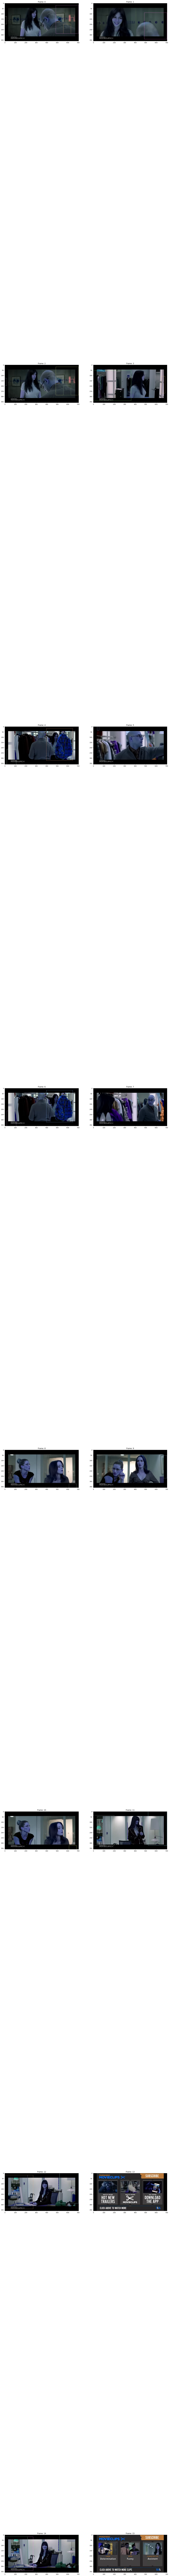

In [49]:
# Print the bounding boxes
show_frames_with_bounding_box(images_list=single_images,
                              bounding_boxes=bounding_boxes_list,
                              row_dim=2, 
                              num_of_images=None)

In [40]:
# Print the results
save_frames_with_bounding_box(images_list=single_images,
                              bounding_boxes=bounding_boxes_list)

100%|██████████| 16/16 [00:00<00:00, 68.39it/s]


## Extract the sub-images from the frames

In [41]:
info_dict = {}

# For each frame
for frame_number in tqdm(range(len(single_images))):
  # Instanciate the info_dict dictionary for the current frame
  info_dict[frame_number] = {}
  # For each bounding box associated to the current frame
  for bb_index in range(len(bounding_boxes_list[frame_number])):
    # Get the current bounding box
    bb = bounding_boxes_list[frame_number][bb_index]
    # Extract the object image from the frame
    bb_image = single_images[frame_number][bb[1]: bb[1]+bb[3], bb[0]: bb[0]+bb[2]] 
    # Define a name for the sub-image
    filename = r"image_" + str(frame_number) + "_" + str(bb_index) + ".png"
    # If save the sub-image if it is valid
    if bb_image.shape[0] > 0 and bb_image.shape[1] > 0:
      cv.imwrite(filename, bb_image)
      # Save the details into the dictionary
      info_dict[frame_number][bb_index] = {}
      info_dict[frame_number][bb_index]["Coordinates"] = bb
      info_dict[frame_number][bb_index]["Image"] = bb_image

100%|██████████| 16/16 [00:00<00:00, 419.89it/s]


In [42]:
# Check the number of bounding boxes saved for each frame
for frame_key, frame_item in info_dict.items():
    print(f'Frame {frame_key} has {len(frame_item.keys())}')

Frame 0 has 1
Frame 1 has 1
Frame 2 has 2
Frame 3 has 2
Frame 4 has 1
Frame 5 has 1
Frame 6 has 1
Frame 7 has 0
Frame 8 has 0
Frame 9 has 1
Frame 10 has 1
Frame 11 has 2
Frame 12 has 2
Frame 13 has 0
Frame 14 has 1
Frame 15 has 0


## Siamese Network comparisons

In [43]:
# Access the info_dict dictionary and compare each image saved